# Routing optical and RF ports

Optical and high speed RF ports have an orientation that routes need to follow to avoid sharp turns that produce reflections.

In [1]:
import numpy as np

# Problem: Sometimes the shortest path does not work well
# Solution: increase separation
# Problem, sometimes when you do path length matching you need to increase the separation
import gdsfactory as gf
from gdsfactory import LAYER
from gdsfactory.cell import cell
from gdsfactory.component import Component
from gdsfactory.port import Port

gf.config.set_plot_options(show_subports=False)
gf.CONF.plotter = "matplotlib"

2023-01-22 16:11:17.063 | INFO     | gdsfactory.config:<module>:50 - Load '/home/runner/work/gdsfactory/gdsfactory/gdsfactory' 6.23.4


2023-01-22 16:11:17.916 | INFO     | gdsfactory.technology.layer_views:__init__:779 - Importing LayerViews from KLayout layer properties file: /home/runner/work/gdsfactory/gdsfactory/gdsfactory/generic_tech/klayout/tech/layers.lyp.


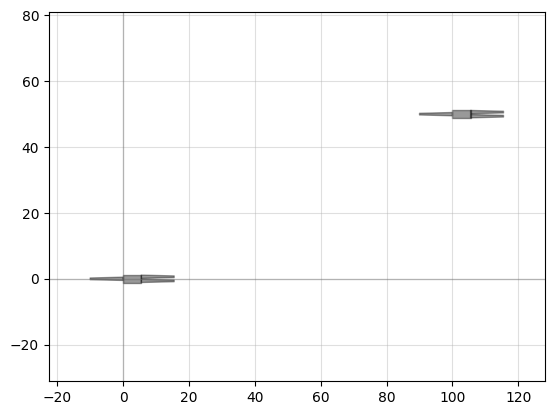

sample_no_routes: uid a21998b8, ports [], references ['mmi1x2_1', 'mmi1x2_2'], 0 polygons

In [2]:
c = gf.Component("sample_no_routes")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
c

## get_route

`get_route` returns a Manhattan route between 2 ports

In [3]:
gf.routing.get_route?

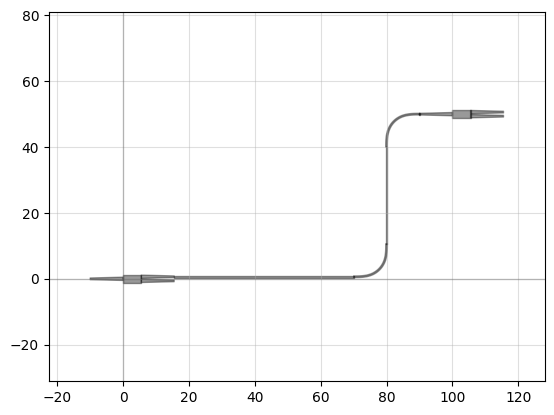

sample_connect: uid 5330d3e2, ports [], references ['mmi1x2_1', 'mmi1x2_2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [4]:
c = gf.Component("sample_connect")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o1"])
c.add(route.references)
c

In [5]:
route

Route(references=[ComponentReference (parent Component "bend_euler", ports ['o1', 'o2'], origin (69.99, 0.625), rotation 0.0, x_reflection False), ComponentReference (parent Component "bend_euler", ports ['o1', 'o2'], origin (79.99, 40.0), rotation 90.0, x_reflection True), ComponentReference (parent Component "straight_df09667e", ports ['o1', 'o2'], origin (15.5, 0.625), rotation 0.0, x_reflection False), ComponentReference (parent Component "straight_f2bf184c", ports ['o1', 'o2'], origin (79.99, 10.625), rotation 90.0, x_reflection False), ComponentReference (parent Component "straight_e1491594", ports ['o1', 'o2'], origin (89.99, 50.0), rotation 0.0, x_reflection False)], labels=[], ports=(Port (name o1, center [15.5    0.625], width 0.5, orientation 180.0, layer (1, 0), port_type optical), Port (name o2, center [90. 50.], width 0.5, orientation 0.0, layer (1, 0), port_type optical)), length=117.149)

**Problem**: get_route with obstacles

sometimes there are obstacles that connect strip does not see!

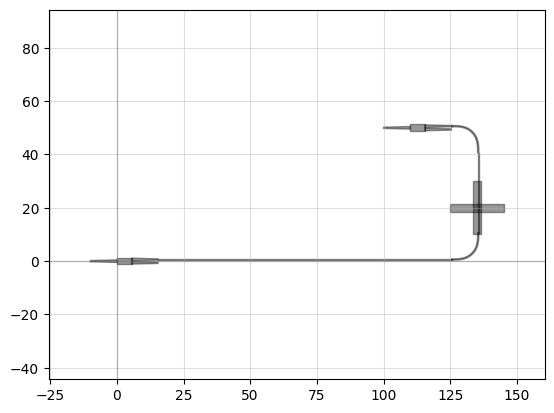

sample_problem: uid 75f7fe79, ports [], references ['mmi1x2_1', 'mmi1x2_2', 'cross_1', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [6]:
c = gf.Component("sample_problem")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))
route = gf.routing.get_route(mmi1.ports["o2"], mmi2.ports["o2"])
c.add(route.references)
c

**Solutions:**

- specify the route waypoints
- specify the route steps

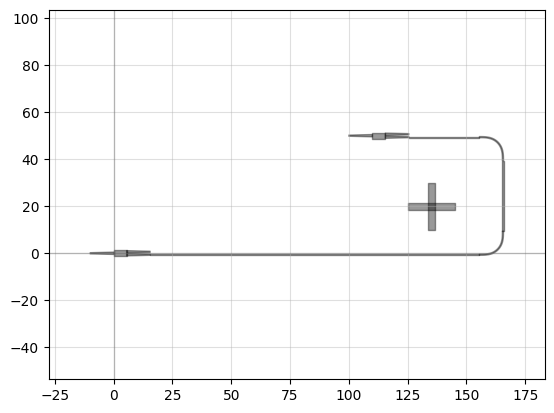

sample_avoid_obstacle: uid 8952cb1f, ports [], references ['mmi1x2_1', 'mmi1x2_2', 'cross_1', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [7]:
c = gf.Component("sample_avoid_obstacle")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((110, 50))
x = c << gf.components.cross(length=20)
x.move((135, 20))

x0 = mmi1.ports["o3"].x
y0 = mmi1.ports["o3"].y


x2 = mmi2.ports["o3"].x
y2 = mmi2.ports["o3"].y

route = gf.routing.get_route_from_waypoints(
    [(x0, y0), (x2 + 40, y0), (x2 + 40, y2), (x2, y2)]
)
c.add(route.references)
c

In [8]:
route.length

233.274

In [9]:
route.ports

(Port (name o1, center [15.5   -0.625], width 0.5, orientation 180.0, layer (1, 0), port_type optical),
 Port (name o2, center [125.5    49.375], width 0.5, orientation 180.0, layer (1, 0), port_type optical))

In [10]:
route.references

[ComponentReference (parent Component "bend_euler", ports ['o1', 'o2'], origin (155.5, -0.625), rotation 0.0, x_reflection False),
 ComponentReference (parent Component "bend_euler", ports ['o1', 'o2'], origin (165.5, 39.375), rotation 90.0, x_reflection False),
 ComponentReference (parent Component "straight_length140p0", ports ['o1', 'o2'], origin (15.5, -0.625), rotation 0.0, x_reflection False),
 ComponentReference (parent Component "straight_length30p0", ports ['o1', 'o2'], origin (165.5, 9.375), rotation 90.0, x_reflection False),
 ComponentReference (parent Component "straight_length30p0", ports ['o1', 'o2'], origin (155.5, 49.375), rotation 180.0, x_reflection False)]

Lets say that we want to extrude the waveguide using a different waveguide crosssection, for example using a different layer

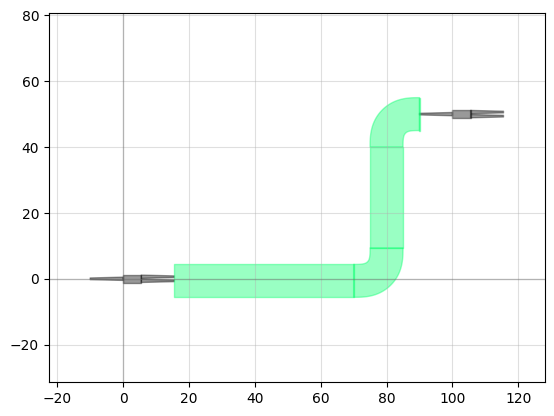

sample_connect_metal: uid 819d808f, ports [], references ['mmi1x2_1', 'mmi1x2_2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [11]:
c = gf.Component("sample_connect_metal")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((100, 50))
route = gf.routing.get_route(
    mmi1.ports["o3"], mmi2.ports["o1"], cross_section=gf.cross_section.metal1, radius=10
)
c.add(route.references)
c

## auto_widen

To reduce loss and phase errors you can also auto-widen waveguide routes straight sections that are longer than a certain length.

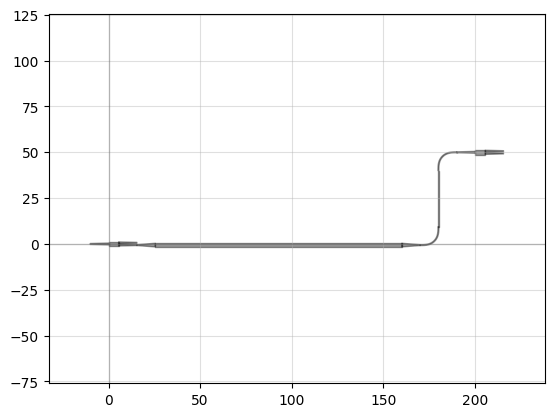

sample_connect_auto_widen: uid 820d15c8, ports [], references ['mmi1x2_1', 'mmi1x2_2', 'bend_euler_1', 'bend_euler_2', 'taper_1', 'straight_1', 'taper_2', 'straight_2', 'straight_3'], 0 polygons

In [12]:
c = gf.Component("sample_connect_auto_widen")
mmi1 = c << gf.components.mmi1x2()
mmi2 = c << gf.components.mmi1x2()
mmi2.move((200, 50))

route = gf.routing.get_route(
    mmi1.ports["o3"],
    mmi2.ports["o1"],
    cross_section=gf.cross_section.strip,
    auto_widen=True,
    width_wide=2,
    auto_widen_minimum_length=100,
)
c.add(route.references)
c

## get_route_from_waypoints

Sometimes you need to set up a route with custom waypoints. `get_route_from_waypoints` is a manual version of `get_route`

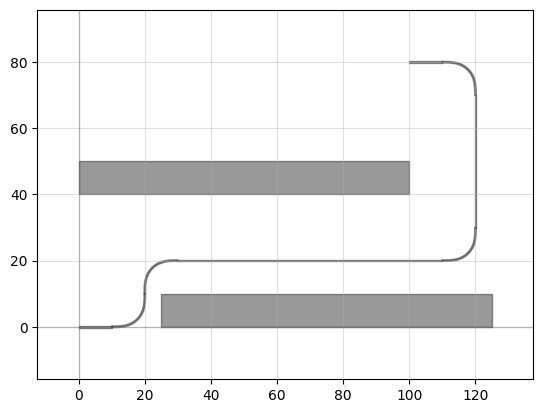

waypoints_sample: uid db7b6fcf, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_3', 'straight_4'], 0 polygons

In [13]:
c = gf.Component("waypoints_sample")

w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25


p0x, p0y = left.ports["o2"].center
p1x, p1y = right.ports["o2"].center
o = 10  # vertical offset to overcome bottom obstacle
ytop = 20


routes = gf.routing.get_route_from_waypoints(
    [
        (p0x, p0y),
        (p0x + o, p0y),
        (p0x + o, ytop),
        (p1x + o, ytop),
        (p1x + o, p1y),
        (p1x, p1y),
    ],
)
c.add(routes.references)
c

## get_route_from_steps

As you can see waypoints can only change one point (x or y) at a time, making the waypoint definition a bit redundant.

You can also use a `get_route_from_steps` which is a more concise route definition, that supports defining only the new steps `x` or `y` together with increments `dx` or `dy`

`get_route_from_steps` is a manual version of `get_route` and a more concise and convenient version of `get_route_from_waypoints`

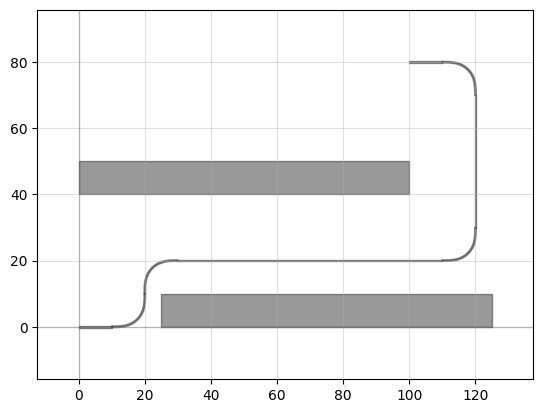

get_route_from_steps: uid 98f39c85, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_3', 'straight_4'], 0 polygons

In [14]:
c = gf.Component("get_route_from_steps")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20, "y": 0},
        {"x": 20, "y": 20},
        {"x": 120, "y": 20},
        {"x": 120, "y": 80},
    ],
)
c.add(routes.references)
c

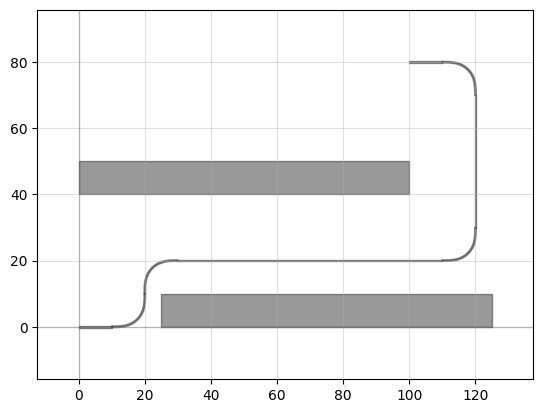

get_route_from_steps_shorter_syntax: uid d209e5c5, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_3', 'straight_4'], 0 polygons

In [15]:
c = gf.Component("get_route_from_steps_shorter_syntax")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

routes = gf.routing.get_route_from_steps(
    port1=port1,
    port2=port2,
    steps=[
        {"x": 20},
        {"y": 20},
        {"x": 120},
        {"y": 80},
    ],
)
c.add(routes.references)
c

## get_route_astar

A* is a routing algorithm that avoid obstacles. See [wikipedia](https://en.wikipedia.org/wiki/A*_search_algorithm) and [animation](https://github.com/zhm-real/PathPlanning)

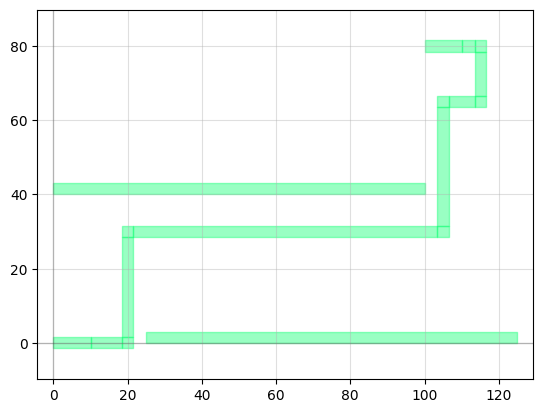

get_route_astar: uid 326a8ce4, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'wire_corner_1', 'wire_corner_2', 'wire_corner_3', 'wire_corner_4', 'wire_corner_5', 'wire_corner_6', 'straight_3', 'straight_4', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'straight_9'], 0 polygons

In [16]:
c = gf.Component("get_route_astar")
cross_section = gf.get_cross_section("metal1", width=3)
w = gf.components.straight(cross_section=cross_section)

left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 3), layer="M1")
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["e2"]
port2 = right.ports["e2"]

routes = gf.routing.get_route_astar(
    component=c,
    port1=port1,
    port2=port2,
    cross_section=cross_section,
    resolution=5,
    distance=6.5,
)

c.add(routes.references)
c

By default it avoids all obstacles on every layer, but you can explicitly define the layers to avoid using `avoid_layers`.

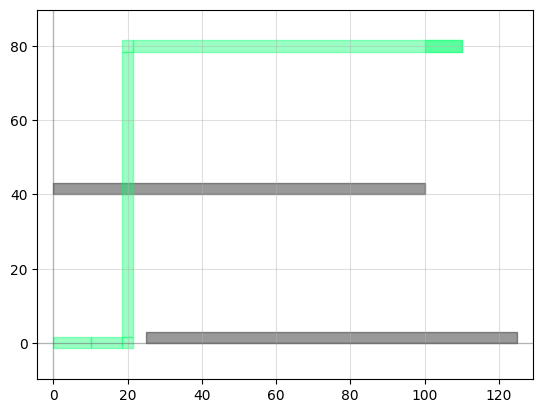

get_route_astar_avoid_layers: uid 675993c8, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'wire_corner_1', 'wire_corner_2', 'straight_3', 'straight_4', 'straight_5'], 0 polygons

In [17]:
c = gf.Component("get_route_astar_avoid_layers")
cross_section = gf.get_cross_section("metal1", width=3)
w = gf.components.straight(cross_section=cross_section)

left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 3), layer="WG")
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["e2"]
port2 = right.ports["e2"]

routes = gf.routing.get_route_astar(
    component=c,
    port1=port1,
    port2=port2,
    cross_section=cross_section,
    resolution=10,
    distance=6.5,
    avoid_layers=("M1",),
)

c.add(routes.references)
c

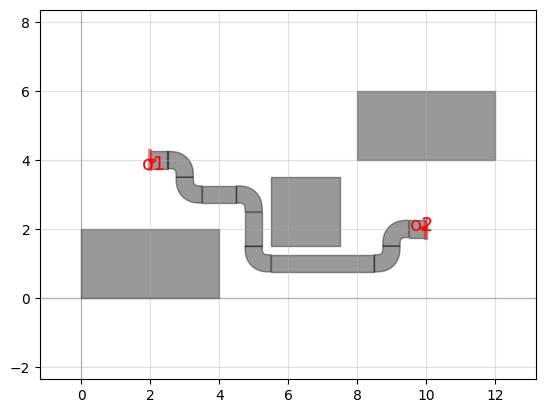

get_route_astar_strip: uid 1c71caae, ports ['o1', 'o2'], references ['rectangle_1', 'rectangle_2', 'rectangle_3', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5'], 0 polygons

In [18]:
c = gf.Component("get_route_astar_strip")
rect1 = c << gf.components.rectangle()
rect2 = c << gf.components.rectangle()
rect3 = c << gf.components.rectangle((2, 2), layer=(1, 0))
rect2.move(destination=(8, 4))
rect3.move(destination=(5.5, 1.5))

port1 = gf.Port(
    "o1", 0, rect1.center + (0, 3), cross_section=gf.get_cross_section("strip")
)
port2 = port1.copy("o2")
port2.orientation = 180
port2.center = rect2.center + (0, -3)
c.add_ports([port1, port2])
route = gf.routing.get_route_astar(c, port1, port2, radius=0.5, width=0.5, distance=0.5)
c.add(route.references)

c

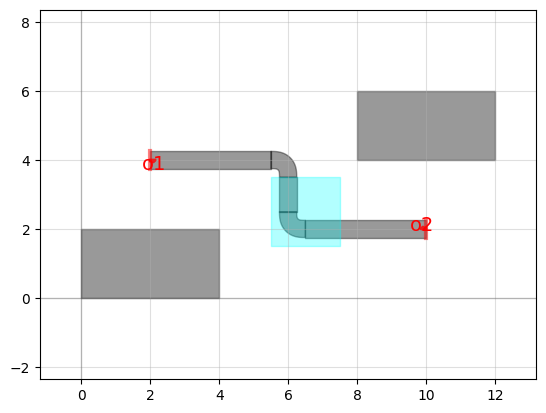

get_route_astar_strip_avoid_layers: uid bcc016f7, ports ['o1', 'o2'], references ['rectangle_1', 'rectangle_2', 'rectangle_3', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [19]:
c = gf.Component("get_route_astar_strip_avoid_layers")
rect1 = c << gf.components.rectangle()
rect2 = c << gf.components.rectangle()
rect3 = c << gf.components.rectangle((2, 2), layer=(2, 0))
rect2.move(destination=(8, 4))
rect3.move(destination=(5.5, 1.5))

port1 = gf.Port(
    "o1", 0, rect1.center + (0, 3), cross_section=gf.get_cross_section("strip")
)
port2 = port1.copy("o2")
port2.orientation = 180
port2.center = rect2.center + (0, -3)
c.add_ports([port1, port2])
route = gf.routing.get_route_astar(
    c, port1, port2, radius=0.5, width=0.5, avoid_layers=[(1, 0)]
)
c.add(route.references)
c

The resolution decides how many "leaps/hops" the algorithm has to do. For a layout like this, where the default resolution (1 micron) is much smaller than the distance between the obstacles (~15+ microns), it has to step through too many points and that takes a long time. Increasing the resolution to about 5 microns fixes it (for this layout).

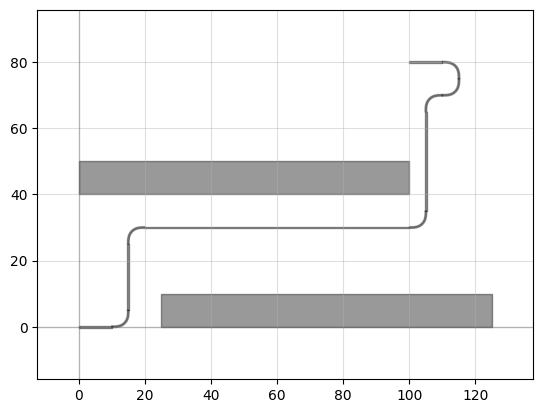

get_route_astar_resolution: uid 0bef6952, ports [], references ['straight_1', 'straight_2', 'rectangle_1', 'rectangle_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_3', 'straight_4', 'straight_5'], 0 polygons

In [20]:
c = gf.Component("get_route_astar_resolution")
w = gf.components.straight()
left = c << w
right = c << w
right.move((100, 80))

obstacle = gf.components.rectangle(size=(100, 10))
obstacle1 = c << obstacle
obstacle2 = c << obstacle
obstacle1.ymin = 40
obstacle2.xmin = 25

port1 = left.ports["o2"]
port2 = right.ports["o2"]

route = gf.routing.get_route_astar(
    component=c,
    port1=port1,
    port2=port2,
    resolution=5,
    distance=5.5,
    radius=5,
)
c.add(route.references)
c

## get_bundle

**Problem**

See the route collisions When connecting groups of ports using `get_route` manhattan single-route router

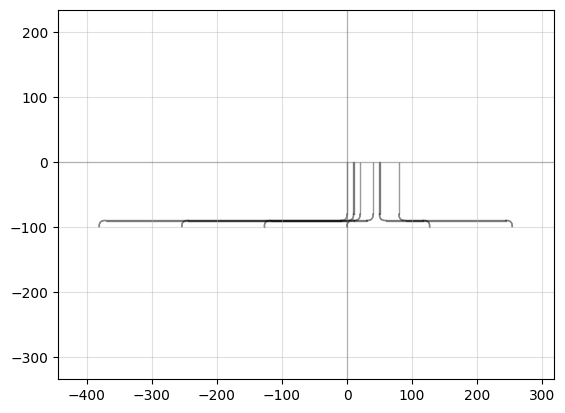

connect_bundle_problem_touching: uid 8982c6cd, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18'], 0 polygons

In [21]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", center=(xs_top[i], 0), width=0.5, orientation=270, layer=layer)
    for i in range(N)
]

bottom_ports = [
    gf.Port(
        f"bottom_{i}",
        center=(xs_bottom[i], -100),
        width=0.5,
        orientation=90,
        layer=layer,
    )
    for i in range(N)
]

c = gf.Component(name="connect_bundle_problem_touching")

for p1, p2 in zip(top_ports, bottom_ports):
    route = gf.routing.get_route(p1, p2)
    c.add(route.references)

c

**solution**

`get_bundle` provides you with river routing capabilities, that you can use to route bundles of ports without collisions

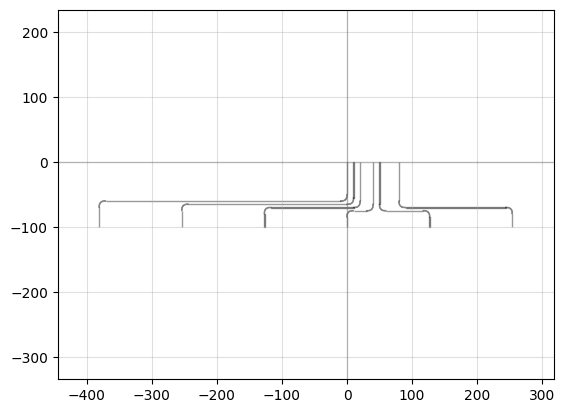

connect_bundle_solution: uid dac22db1, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18'], 0 polygons

In [22]:
c = gf.Component(name="connect_bundle_solution")
routes = gf.routing.get_bundle(top_ports, bottom_ports)
for route in routes:
    c.add(route.references)

c

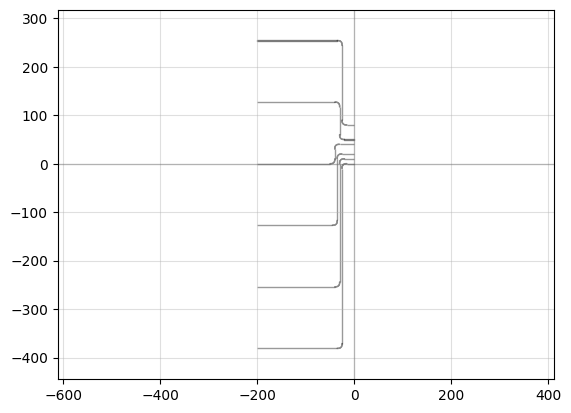

connect_bundle_v2: uid 3e1cc541, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18'], 0 polygons

In [23]:
ys_right = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(ys_right)
ys_left = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-200, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]

# you can also mess up the port order and it will sort them by default
left_ports.reverse()

c = gf.Component(name="connect_bundle_v2")
routes = gf.routing.get_bundle(
    left_ports, right_ports, sort_ports=True, start_straight_length=100
)
for route in routes:
    c.add(route.references)
c

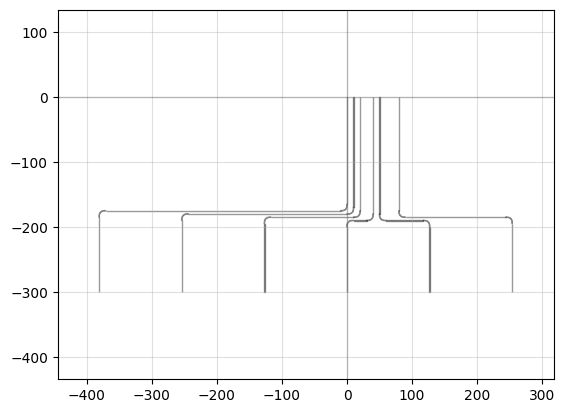

connect_bundle_separation: uid 5685e44c, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18'], 0 polygons

In [24]:
xs_top = [0, 10, 20, 40, 50, 80]
pitch = 127.0
N = len(xs_top)
xs_bottom = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

top_ports = [
    gf.Port(f"top_{i}", center=(xs_top[i], 0), width=0.5, orientation=270, layer=layer)
    for i in range(N)
]

bot_ports = [
    gf.Port(
        f"bot_{i}",
        center=(xs_bottom[i], -300),
        width=0.5,
        orientation=90,
        layer=layer,
    )
    for i in range(N)
]

c = gf.Component(name="connect_bundle_separation")
routes = gf.routing.get_bundle(
    top_ports, bot_ports, separation=5.0, end_straight_length=100
)
for route in routes:
    c.add(route.references)

c

`get_bundle` can also route bundles through corners

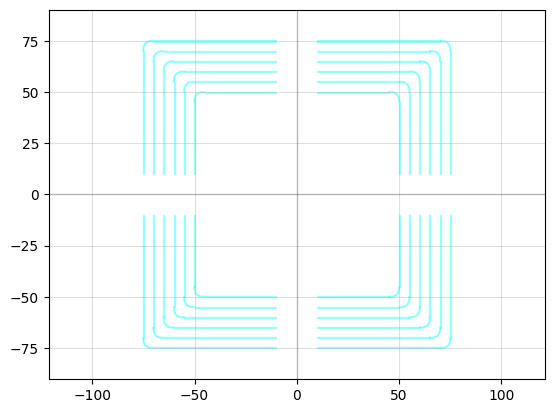

test_connect_corner: uid 26719ac2, ports [], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'straight_5', 'straight_6', 'bend_euler_4', 'straight_7', 'straight_8', 'bend_euler_5', 'straight_9', 'straight_10', 'bend_euler_6', 'straight_11', 'straight_12', 'bend_euler_7', 'straight_13', 'straight_14', 'bend_euler_8', 'straight_15', 'straight_16', 'bend_euler_9', 'straight_17', 'straight_18', 'bend_euler_10', 'straight_19', 'straight_20', 'bend_euler_11', 'straight_21', 'straight_22', 'bend_euler_12', 'straight_23', 'straight_24', 'bend_euler_13', 'straight_25', 'straight_26', 'bend_euler_14', 'straight_27', 'straight_28', 'bend_euler_15', 'straight_29', 'straight_30', 'bend_euler_16', 'straight_31', 'straight_32', 'bend_euler_17', 'straight_33', 'straight_34', 'bend_euler_18', 'straight_35', 'straight_36', 'bend_euler_19', 'straight_37', 'straight_38', 'bend_euler_20', 'straight_39', 'straight_40', 'bend_euler_21', 'straight_41', 'straight_42', 'bend_euler_22', 'straight_43', 'straight_44', 'bend_euler_23', 'straight_45', 'straight_46', 'bend_euler_24', 'straight_47', 'straight_48'], 0 polygons

In [25]:
@cell
def test_connect_corner(N=6, config="A"):
    d = 10.0
    sep = 5.0
    top_cell = gf.Component()
    layer = (1, 0)

    if config in ["A", "B"]:
        a = 100.0
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(d, a / 2 + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-d, a / 2 + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(d, -a / 2 - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-d, -a / 2 - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(a / 2 + i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-a / 2 - i * sep, d),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(a / 2 + i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-a / 2 - i * sep, -d),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    elif config in ["C", "D"]:
        a = N * sep + 2 * d
        ports_A_TR = [
            Port(
                f"A_TR_{i}",
                center=(a, d + i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_TL = [
            Port(
                f"A_TL_{i}",
                center=(-a, d + i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BR = [
            Port(
                f"A_BR_{i}",
                center=(a, -d - i * sep),
                width=0.5,
                orientation=0,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A_BL = [
            Port(
                f"A_BL_{i}",
                center=(-a, -d - i * sep),
                width=0.5,
                orientation=180,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_A = [ports_A_TR, ports_A_TL, ports_A_BR, ports_A_BL]

        ports_B_TR = [
            Port(
                f"B_TR_{i}",
                center=(d + i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_TL = [
            Port(
                f"B_TL_{i}",
                center=(-d - i * sep, a),
                width=0.5,
                orientation=90,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BR = [
            Port(
                f"B_BR_{i}",
                center=(d + i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B_BL = [
            Port(
                f"B_BL_{i}",
                center=(-d - i * sep, -a),
                width=0.5,
                orientation=270,
                layer=layer,
            )
            for i in range(N)
        ]

        ports_B = [ports_B_TR, ports_B_TL, ports_B_BR, ports_B_BL]

    if config in ["A", "C"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports1, ports2, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    elif config in ["B", "D"]:
        for ports1, ports2 in zip(ports_A, ports_B):
            routes = gf.routing.get_bundle(ports2, ports1, layer=(2, 0), radius=5)
            for route in routes:
                top_cell.add(route.references)

    return top_cell


c = test_connect_corner(config="A")
c

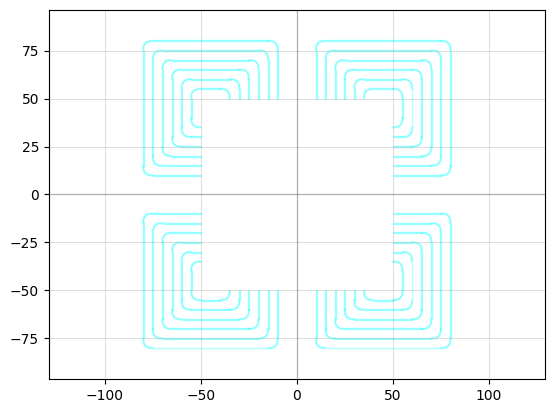

test_connect_corner_configC: uid 01c8079b, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'straight_9', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_13', 'straight_14', 'straight_15', 'straight_16', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'bend_euler_19', 'bend_euler_20', 'bend_euler_21', 'straight_25', 'straight_26', 'straight_27', 'straight_28', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_29', 'straight_30', 'straight_31', 'straight_32', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'straight_33', 'straight_34', 'straight_35', 'straight_36', 'bend_euler_28', 'bend_euler_29', 'bend_euler_30', 'straight_37', 'straight_38', 'straight_39', 'straight_40', 'bend_euler_31', 'bend_euler_32', 'bend_euler_33', 'straight_41', 'straight_42', 'straight_43', 'straight_44', 'bend_euler_34', 'bend_euler_35', 'bend_euler_36', 'straight_45', 'straight_46', 'straight_47', 'straight_48', 'bend_euler_37', 'bend_euler_38', 'bend_euler_39', 'straight_49', 'straight_50', 'straight_51', 'straight_52', 'bend_euler_40', 'bend_euler_41', 'bend_euler_42', 'straight_53', 'straight_54', 'straight_55', 'straight_56', 'bend_euler_43', 'bend_euler_44', 'bend_euler_45', 'straight_57', 'straight_58', 'straight_59', 'straight_60', 'bend_euler_46', 'bend_euler_47', 'bend_euler_48', 'straight_61', 'straight_62', 'straight_63', 'straight_64', 'bend_euler_49', 'bend_euler_50', 'bend_euler_51', 'straight_65', 'straight_66', 'straight_67', 'straight_68', 'bend_euler_52', 'bend_euler_53', 'bend_euler_54', 'straight_69', 'straight_70', 'straight_71', 'straight_72', 'bend_euler_55', 'bend_euler_56', 'bend_euler_57', 'straight_73', 'straight_74', 'straight_75', 'straight_76', 'bend_euler_58', 'bend_euler_59', 'bend_euler_60', 'straight_77', 'straight_78', 'straight_79', 'straight_80', 'bend_euler_61', 'bend_euler_62', 'bend_euler_63', 'straight_81', 'straight_82', 'straight_83', 'straight_84', 'bend_euler_64', 'bend_euler_65', 'bend_euler_66', 'straight_85', 'straight_86', 'straight_87', 'straight_88', 'bend_euler_67', 'bend_euler_68', 'bend_euler_69', 'straight_89', 'straight_90', 'straight_91', 'straight_92', 'bend_euler_70', 'bend_euler_71', 'bend_euler_72', 'straight_93', 'straight_94', 'straight_95', 'straight_96'], 0 polygons

In [26]:
c = test_connect_corner(config="C")
c

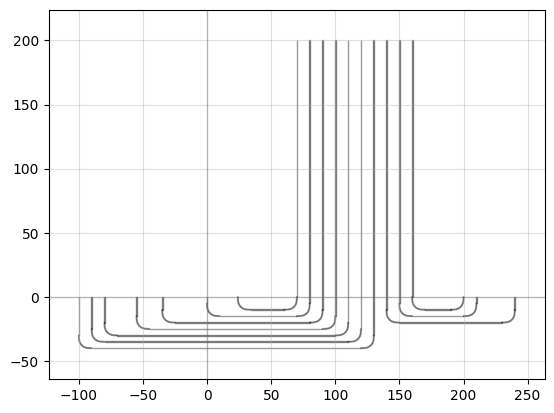

test_connect_bundle_udirect: uid c9a01736, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18', 'bend_euler_13', 'bend_euler_14', 'straight_19', 'straight_20', 'straight_21', 'bend_euler_15', 'bend_euler_16', 'straight_22', 'straight_23', 'straight_24', 'bend_euler_17', 'bend_euler_18', 'straight_25', 'straight_26', 'straight_27', 'bend_euler_19', 'bend_euler_20', 'straight_28', 'straight_29', 'straight_30'], 0 polygons

In [27]:
@cell
def test_connect_bundle_udirect(dy=200, orientation=270, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35, 24, 0] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [70 + i * pitch for i in range(N)]

    if axis == "X":
        ports1 = [
            Port(
                f"top_{i}",
                center=(0, xs1[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(
                f"top_{i}",
                center=(xs1[i], 0),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bottom_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=orientation,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(ports1, ports2, radius=10.0)
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_udirect()
c

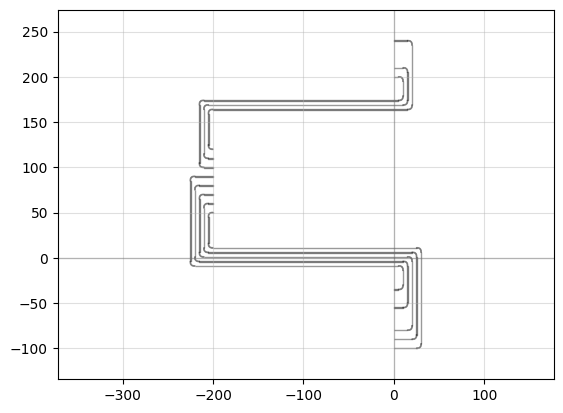

test_connect_bundle_u_i_d8b895b0: uid 136574bc, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'straight_16', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_17', 'bend_euler_18', 'bend_euler_19', 'bend_euler_20', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_26', 'straight_27', 'straight_28', 'straight_29', 'straight_30', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'bend_euler_28', 'straight_31', 'straight_32', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_29', 'bend_euler_30', 'bend_euler_31', 'bend_euler_32', 'straight_36', 'straight_37', 'straight_38', 'straight_39', 'straight_40'], 0 polygons

In [28]:
@cell
def test_connect_bundle_u_indirect(dy=-200, orientation=180, layer=(1, 0)):
    xs1 = [-100, -90, -80, -55, -35] + [200, 210, 240]
    axis = "X" if orientation in [0, 180] else "Y"
    pitch = 10.0
    N = len(xs1)
    xs2 = [50 + i * pitch for i in range(N)]

    a1 = orientation
    a2 = a1 + 180

    if axis == "X":
        ports1 = [
            Port(f"top_{i}", center=(0, xs1[i]), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(dy, xs2[i]),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    else:
        ports1 = [
            Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
            for i in range(N)
        ]

        ports2 = [
            Port(
                f"bot_{i}",
                center=(xs2[i], dy),
                width=0.5,
                orientation=a2,
                layer=layer,
            )
            for i in range(N)
        ]

    top_cell = Component()
    routes = gf.routing.get_bundle(
        ports1,
        ports2,
        bend=gf.components.bend_euler,
        radius=5,
    )
    for route in routes:
        top_cell.add(route.references)

    return top_cell


c = test_connect_bundle_u_indirect(orientation=0)
c

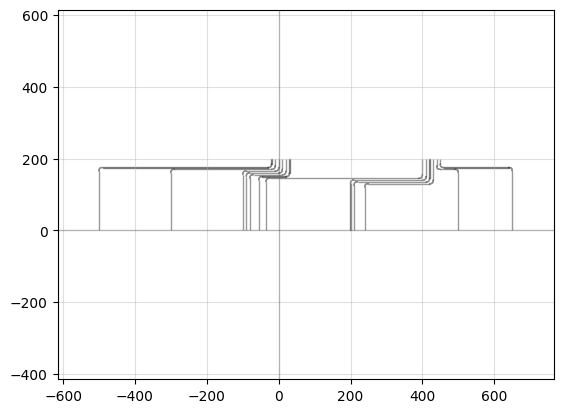

test_north_to_south: uid a535cc15, ports [], references ['bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'bend_euler_9', 'bend_euler_10', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_11', 'bend_euler_12', 'straight_16', 'straight_17', 'straight_18', 'bend_euler_13', 'bend_euler_14', 'straight_19', 'straight_20', 'straight_21', 'bend_euler_15', 'bend_euler_16', 'straight_22', 'straight_23', 'straight_24', 'bend_euler_17', 'bend_euler_18', 'straight_25', 'straight_26', 'straight_27', 'bend_euler_19', 'bend_euler_20', 'straight_28', 'straight_29', 'straight_30', 'bend_euler_21', 'bend_euler_22', 'straight_31', 'straight_32', 'straight_33', 'bend_euler_23', 'bend_euler_24', 'straight_34', 'straight_35', 'straight_36'], 0 polygons

In [29]:
@gf.cell
def test_north_to_south(layer=(1, 0)):
    dy = 200.0
    xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

    pitch = 10.0
    N = len(xs1)
    xs2 = [-20 + i * pitch for i in range(N // 2)]
    xs2 += [400 + i * pitch for i in range(N // 2)]

    a1 = 90
    a2 = a1 + 180

    ports1 = [
        gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
        for i in range(N)
    ]

    ports2 = [
        gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
        for i in range(N)
    ]

    c = gf.Component()
    routes = gf.routing.get_bundle(ports1, ports2, auto_widen=False)
    for route in routes:
        c.add(route.references)

    return c


c = test_north_to_south()
c

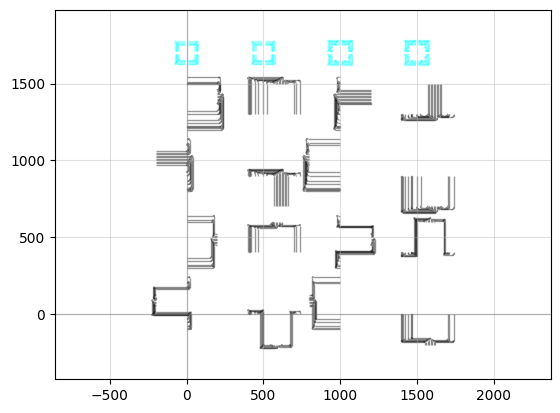

demo_connect_bundle: uid e92ac1ad, ports [], references ['test_connect_bundle_u_indirect_1', 'test_connect_bundle_udirect_1', 'test_connect_bundle_u_indirect_2', 'test_connect_bundle_udirect_2', 'test_connect_bundle_u_indirect_3', 'test_connect_bundle_udirect_3', 'test_connect_bundle_u_indirect_4', 'test_connect_bundle_udirect_4', 'test_connect_bundle_u_indirect_5', 'test_connect_bundle_udirect_5', 'test_connect_bundle_u_indirect_6', 'test_connect_bundle_udirect_6', 'test_connect_bundle_u_indirect_7', 'test_connect_bundle_udirect_7', 'test_connect_bundle_u_indirect_8', 'test_connect_bundle_udirect_8', 'test_connect_corner_1', 'test_connect_corner_2', 'test_connect_corner_3', 'test_connect_corner_4'], 0 polygons

In [30]:
@gf.cell
def demo_connect_bundle():
    """combines all the connect_bundle tests"""
    y = 400.0
    x = 500
    y0 = 900
    dy = 200.0
    c = gf.Component()
    for j, s in enumerate([-1, 1]):
        for i, orientation in enumerate([0, 90, 180, 270]):
            ci = test_connect_bundle_u_indirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y))
            c.add(ref)

            ci = test_connect_bundle_udirect(dy=s * dy, orientation=orientation)
            ref = ci.ref(position=(i * x, j * y + y0))
            c.add(ref)

    for i, config in enumerate(["A", "B", "C", "D"]):
        ci = test_connect_corner(config=config)
        ref = ci.ref(position=(i * x, 1700))
        c.add(ref)

    return c


c = demo_connect_bundle()
c

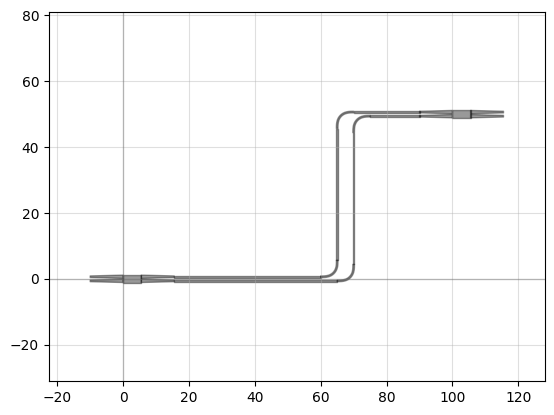

route_bend_5um: uid 2d76b6bc, ports [], references ['mmi2x2_1', 'mmi2x2_2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6'], 0 polygons

In [31]:
c = gf.Component("route_bend_5um")
c1 = c << gf.components.mmi2x2()
c2 = c << gf.components.mmi2x2()

c2.move((100, 50))
routes = gf.routing.get_bundle(
    [c1.ports["o4"], c1.ports["o3"]], [c2.ports["o1"], c2.ports["o2"]], radius=5
)
for route in routes:
    c.add(route.references)
c

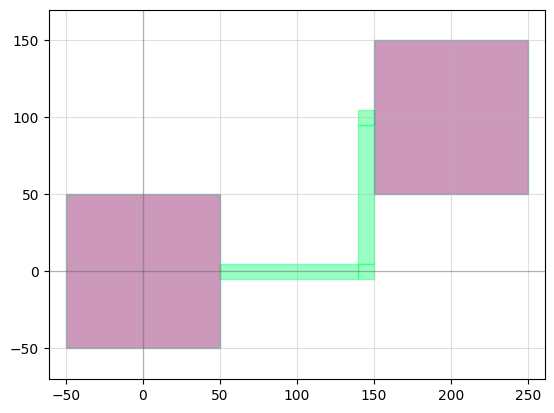

electrical: uid 42f87ee3, ports [], references ['pad_1', 'pad_2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3'], 0 polygons

In [32]:
c = gf.Component("electrical")
c1 = c << gf.components.pad()
c2 = c << gf.components.pad()
c2.move((200, 100))
routes = gf.routing.get_bundle(
    [c1.ports["e3"]], [c2.ports["e1"]], cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c

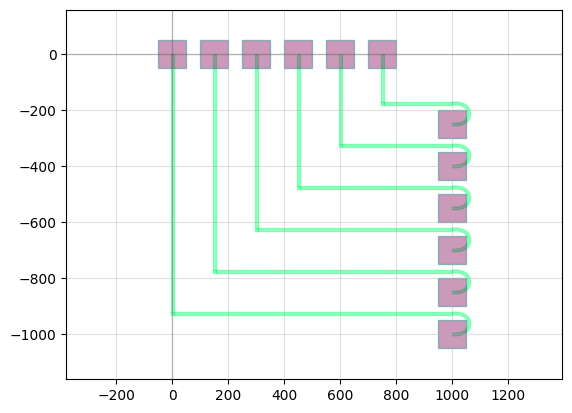

get_bundle_with_ubends_bend_from_top: uid 46221ad7, ports [], references ['pad_array_1', 'pad_array_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'straight_1', 'straight_2', 'bend_euler_8', 'straight_3', 'straight_4', 'bend_euler_9', 'straight_5', 'straight_6', 'bend_euler_10', 'straight_7', 'straight_8', 'bend_euler_11', 'straight_9', 'straight_10', 'bend_euler_12', 'straight_11', 'straight_12'], 0 polygons

In [33]:
c = gf.Component("get_bundle_with_ubends_bend_from_top")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e1",
    bend_port2="e2",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c

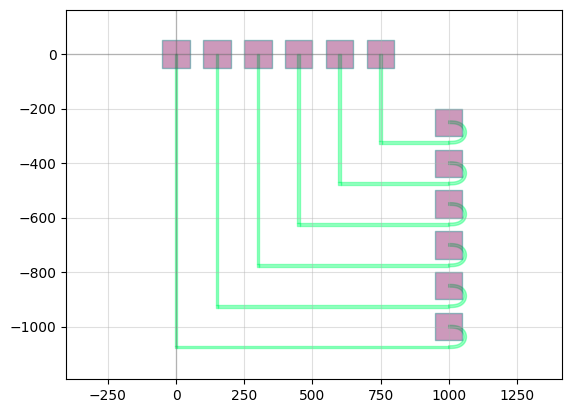

get_bundle_with_ubends_bend_from_bottom: uid ebdbbf8e, ports [], references ['pad_array_1', 'pad_array_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'straight_1', 'straight_2', 'bend_euler_8', 'straight_3', 'straight_4', 'bend_euler_9', 'straight_5', 'straight_6', 'bend_euler_10', 'straight_7', 'straight_8', 'bend_euler_11', 'straight_9', 'straight_10', 'bend_euler_12', 'straight_11', 'straight_12'], 0 polygons

In [34]:
c = gf.Component("get_bundle_with_ubends_bend_from_bottom")
pad_array = gf.components.pad_array()

c1 = c << pad_array
c2 = c << pad_array
c2.rotate(90)
c2.movex(1000)
c2.ymax = -200

routes_bend180 = gf.routing.get_routes_bend180(
    ports=c2.get_ports_list(),
    radius=75 / 2,
    cross_section=gf.cross_section.metal1,
    bend_port1="e2",
    bend_port2="e1",
)
c.add(routes_bend180.references)

routes = gf.routing.get_bundle(
    c1.get_ports_list(), routes_bend180.ports, cross_section=gf.cross_section.metal1
)
for route in routes:
    c.add(route.references)
c

**Problem**

Sometimes 90 degrees routes do not have enough space for a Manhattan route

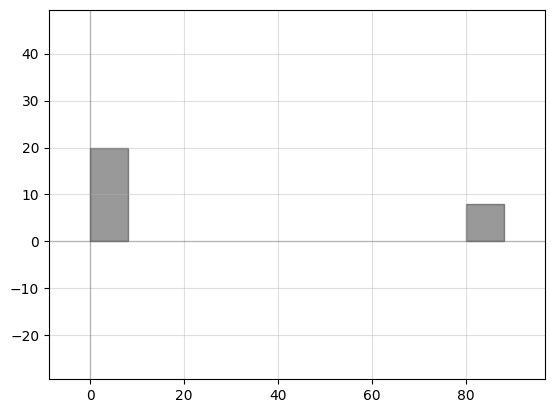

route_fail_1: uid e7c5d32d, ports [], references ['nxn_1', 'nxn_2'], 0 polygons

In [35]:
c = gf.Component("route_fail_1")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
c

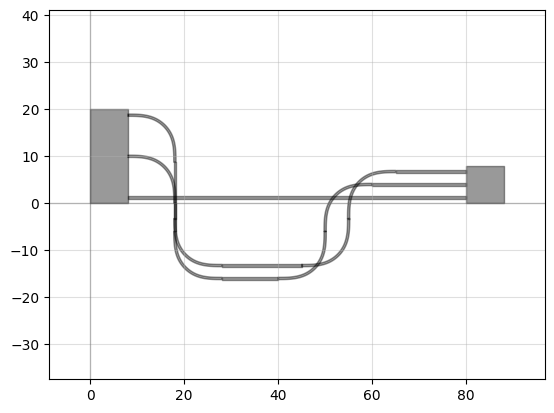

route_fail_v2: uid ba4a67aa, ports [], references ['nxn_1', 'nxn_2', 'straight_1', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_7', 'straight_8', 'straight_9', 'straight_10', 'straight_11'], 0 polygons

In [36]:
c = gf.Component("route_fail_v2")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    auto_widen=False,
)
for route in routes:
    c.add(route.references)
c

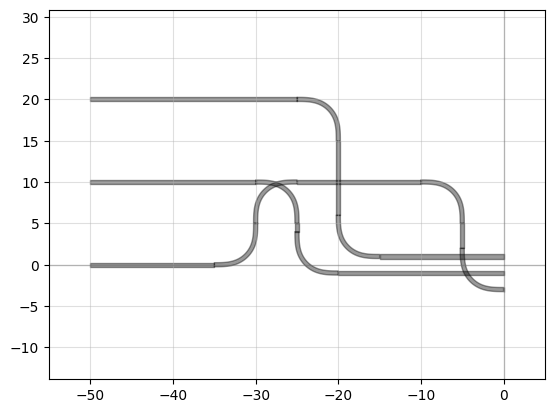

route_fail_v3: uid 9d4ae843, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_5', 'bend_euler_6', 'straight_6', 'straight_7', 'straight_8', 'bend_euler_7', 'bend_euler_8', 'straight_9', 'straight_10', 'straight_11'], 0 polygons

In [37]:
c = gf.Component("route_fail_v3")
pitch = 2.0
ys_left = [0, 10, 20]
N = len(ys_left)
ys_right = [(i - N / 2) * pitch for i in range(N)]
layer = (1, 0)

right_ports = [
    gf.Port(f"R_{i}", center=(0, ys_right[i]), width=0.5, orientation=180, layer=layer)
    for i in range(N)
]
left_ports = [
    gf.Port(f"L_{i}", center=(-50, ys_left[i]), width=0.5, orientation=0, layer=layer)
    for i in range(N)
]
left_ports.reverse()
routes = gf.routing.get_bundle(right_ports, left_ports, radius=5)

for route in routes:
    c.add(route.references)
c

**Solution**

Add Sbend routes using `get_bundle_sbend`

/home/runner/work/gdsfactory/gdsfactory/gdsfactory/components/bezier.py:73: RuntimeWarning: divide by zero encountered in scalar divide
  min_bend_radius = gf.snap.snap_to_grid(1 / max(np.abs(curv)))


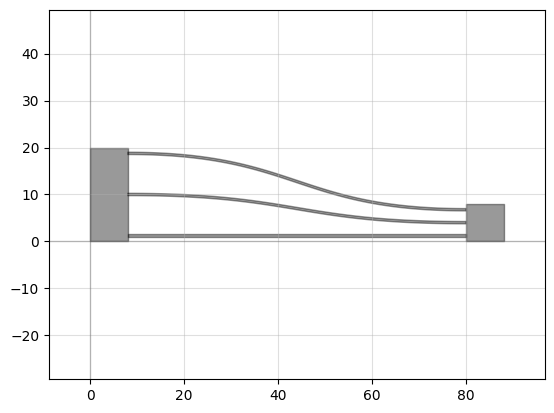

route_solution_1_get_bundle_sbend: uid b9918b07, ports [], references ['nxn_1', 'nxn_2', 'bend_s_1', 'bend_s_2', 'bend_s_3'], 0 polygons

In [38]:
c = gf.Component("route_solution_1_get_bundle_sbend")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle_sbend(
    c1.get_ports_list(orientation=0), c2.get_ports_list(orientation=180)
)
for route in routes:
    c.add(route.references)
c

You can also `get_bundle` adding `with_sbend=True`

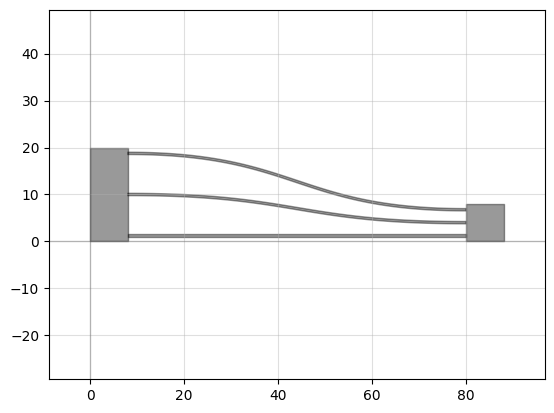

route_solution_2_get_bundle: uid 4ff455ac, ports [], references ['nxn_1', 'nxn_2', 'bend_s_1', 'bend_s_2', 'bend_s_3'], 0 polygons

In [39]:
c = gf.Component("route_solution_2_get_bundle")
c1 = c << gf.components.nxn(east=3, ysize=20)
c2 = c << gf.components.nxn(west=3)
c2.move((80, 0))
routes = gf.routing.get_bundle(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    with_sbend=True,
)
for route in routes:
    c.add(route.references)
c

## get_bundle_from_waypoints

While `get_bundle` routes bundles of ports automatically, you can also use `get_bundle_from_waypoints` to manually specify the route waypoints.

You can think of `get_bundle_from_waypoints` as a manual version of `get_bundle`

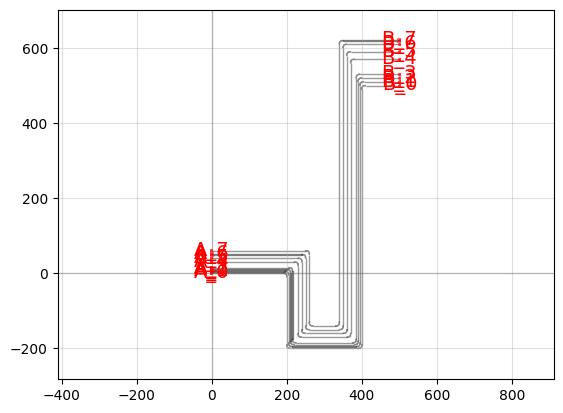

test_connect_bundle_waypoints: uid 204314f2, ports ['A_0', 'A_1', 'A_2', 'A_3', 'A_4', 'A_5', 'A_6', 'A_7', 'B_0', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7'], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'straight_16', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_17', 'bend_euler_18', 'bend_euler_19', 'bend_euler_20', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_26', 'straight_27', 'straight_28', 'straight_29', 'straight_30', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'bend_euler_28', 'straight_31', 'straight_32', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_29', 'bend_euler_30', 'bend_euler_31', 'bend_euler_32', 'straight_36', 'straight_37', 'straight_38', 'straight_39', 'straight_40'], 0 polygons

In [40]:
@gf.cell
def test_connect_bundle_waypoints(layer=(1, 0)):
    """Connect bundle of ports with bundle of routes following a list of waypoints."""
    ys1 = np.array([0, 5, 10, 15, 30, 40, 50, 60]) + 0.0
    ys2 = np.array([0, 10, 20, 30, 70, 90, 110, 120]) + 500.0
    N = ys1.size

    ports1 = [
        gf.Port(
            name=f"A_{i}", center=(0, ys1[i]), width=0.5, orientation=0, layer=layer
        )
        for i in range(N)
    ]
    ports2 = [
        gf.Port(
            name=f"B_{i}",
            center=(500, ys2[i]),
            width=0.5,
            orientation=180,
            layer=layer,
        )
        for i in range(N)
    ]

    p0 = ports1[0].center

    c = gf.Component()
    c.add_ports(ports1)
    c.add_ports(ports2)
    waypoints = [
        p0 + (200, 0),
        p0 + (200, -200),
        p0 + (400, -200),
        (p0[0] + 400, ports2[0].y),
    ]

    routes = gf.routing.get_bundle_from_waypoints(ports1, ports2, waypoints)
    lengths = {}
    for i, route in enumerate(routes):
        c.add(route.references)
        lengths[i] = route.length

    return c


cell = test_connect_bundle_waypoints()
cell

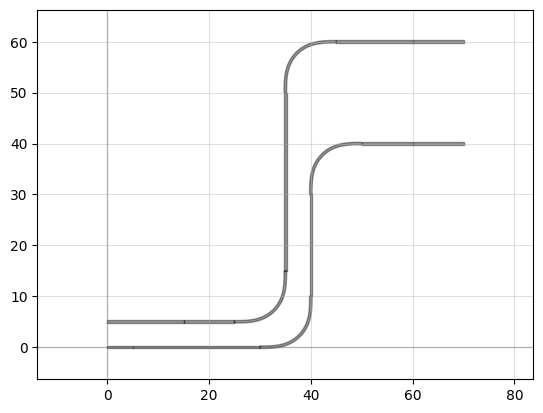

demo_get_bundle: uid b9328337, ports [], references ['array_1', 'straight_1', 'straight_2', 'bend_euler_1', 'bend_euler_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_3', 'bend_euler_4', 'straight_6', 'straight_7', 'straight_8'], 0 polygons

In [41]:
c = gf.Component("demo_get_bundle")
r = c << gf.components.array(
    component=gf.components.straight, rows=2, columns=1, spacing=(0, 20)
)

r.movex(60)
r.movey(40)

lt = c << gf.components.straight(length=15)
lb = c << gf.components.straight(length=5)
lt.movey(5)

ports1 = lt.get_ports_list(orientation=0) + lb.get_ports_list(orientation=0)
ports2 = r.get_ports_list(orientation=180)


dx = 20
p0 = ports1[0].center + (dx, 0)
p1 = (ports1[0].center[0] + dx, ports2[0].center[1])
waypoints = (p0, p1)

routes = gf.routing.get_bundle_from_waypoints(ports1, ports2, waypoints=waypoints)
for route in routes:
    c.add(route.references)
c

## get_bundle_from_steps

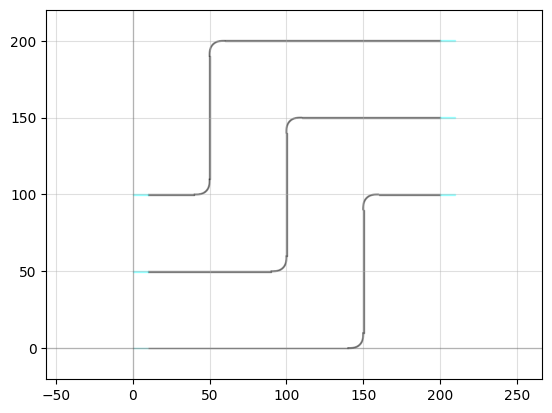

get_route_from_steps_sample: uid 3839765e, ports [], references ['array_1', 'array_2', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9'], 0 polygons

In [42]:
c = gf.Component("get_route_from_steps_sample")
w = gf.components.array(
    gf.partial(gf.components.straight, layer=(2, 0)),
    rows=3,
    columns=1,
    spacing=(0, 50),
)

left = c << w
right = c << w
right.move((200, 100))
p1 = left.get_ports_list(orientation=0)
p2 = right.get_ports_list(orientation=180)

routes = gf.routing.get_bundle_from_steps(
    p1,
    p2,
    steps=[{"x": 150}],
)

for route in routes:
    c.add(route.references)

c

## get_bundle_path_length_match

Sometimes you need to set up a route a bundle of ports that need to keep the same lengths

2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822
2659.822


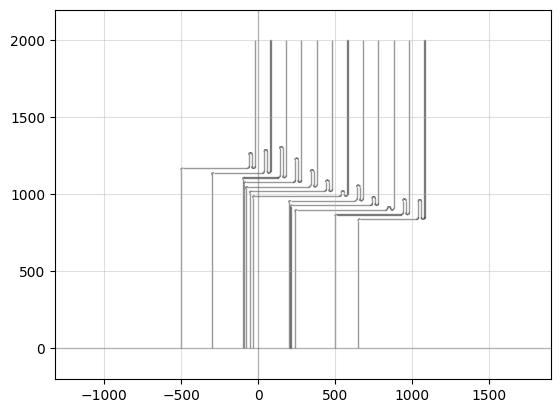

path_length_match_sample: uid 3f6de3f6, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_19', 'bend_euler_20', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_16', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'bend_euler_28', 'bend_euler_29', 'bend_euler_30', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'bend_euler_31', 'bend_euler_32', 'bend_euler_33', 'bend_euler_34', 'bend_euler_35', 'bend_euler_36', 'straight_26', 'straight_27', 'straight_28', 'straight_29', 'straight_30', 'bend_euler_37', 'bend_euler_38', 'bend_euler_39', 'bend_euler_40', 'bend_euler_41', 'bend_euler_42', 'straight_31', 'straight_32', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_43', 'bend_euler_44', 'bend_euler_45', 'bend_euler_46', 'bend_euler_47', 'bend_euler_48', 'straight_36', 'straight_37', 'straight_38', 'straight_39', 'straight_40', 'bend_euler_49', 'bend_euler_50', 'bend_euler_51', 'bend_euler_52', 'bend_euler_53', 'bend_euler_54', 'straight_41', 'straight_42', 'straight_43', 'straight_44', 'straight_45', 'bend_euler_55', 'bend_euler_56', 'bend_euler_57', 'bend_euler_58', 'bend_euler_59', 'bend_euler_60', 'straight_46', 'straight_47', 'straight_48', 'bend_euler_61', 'bend_euler_62', 'bend_euler_63', 'bend_euler_64', 'bend_euler_65', 'bend_euler_66', 'straight_49', 'straight_50', 'straight_51', 'straight_52', 'straight_53', 'bend_euler_67', 'bend_euler_68', 'bend_euler_69', 'bend_euler_70', 'bend_euler_71', 'bend_euler_72', 'straight_54', 'straight_55', 'straight_56', 'straight_57', 'straight_58'], 0 polygons

In [43]:
c = gf.Component("path_length_match_sample")
dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle_path_length_match(ports1, ports2)

for route in routes:
    c.add(route.references)
    print(route.length)
c

### Add extra length

You can also add some extra length to all the routes

2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822
2703.822


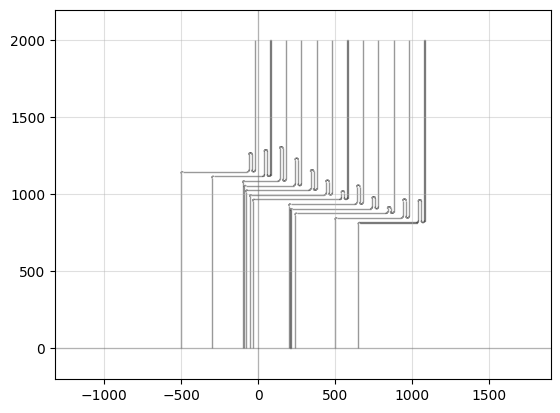

path_length_match_sample_extra_length: uid 86e6ec3a, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'bend_euler_19', 'bend_euler_20', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_16', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'bend_euler_28', 'bend_euler_29', 'bend_euler_30', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'bend_euler_31', 'bend_euler_32', 'bend_euler_33', 'bend_euler_34', 'bend_euler_35', 'bend_euler_36', 'straight_26', 'straight_27', 'straight_28', 'straight_29', 'straight_30', 'bend_euler_37', 'bend_euler_38', 'bend_euler_39', 'bend_euler_40', 'bend_euler_41', 'bend_euler_42', 'straight_31', 'straight_32', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_43', 'bend_euler_44', 'bend_euler_45', 'bend_euler_46', 'bend_euler_47', 'bend_euler_48', 'straight_36', 'straight_37', 'straight_38', 'straight_39', 'straight_40', 'bend_euler_49', 'bend_euler_50', 'bend_euler_51', 'bend_euler_52', 'bend_euler_53', 'bend_euler_54', 'straight_41', 'straight_42', 'straight_43', 'straight_44', 'straight_45', 'bend_euler_55', 'bend_euler_56', 'bend_euler_57', 'bend_euler_58', 'bend_euler_59', 'bend_euler_60', 'straight_46', 'straight_47', 'straight_48', 'straight_49', 'straight_50', 'bend_euler_61', 'bend_euler_62', 'bend_euler_63', 'bend_euler_64', 'bend_euler_65', 'bend_euler_66', 'straight_51', 'straight_52', 'straight_53', 'straight_54', 'straight_55', 'bend_euler_67', 'bend_euler_68', 'bend_euler_69', 'bend_euler_70', 'bend_euler_71', 'bend_euler_72', 'straight_56', 'straight_57', 'straight_58', 'straight_59', 'straight_60'], 0 polygons

In [44]:
c = gf.Component("path_length_match_sample_extra_length")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 100.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle_path_length_match(ports1, ports2, extra_length=44)
for route in routes:
    c.add(route.references)
    print(route.length)
c

### increase number of loops

You can also increase the number of loops

3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37
3586.37


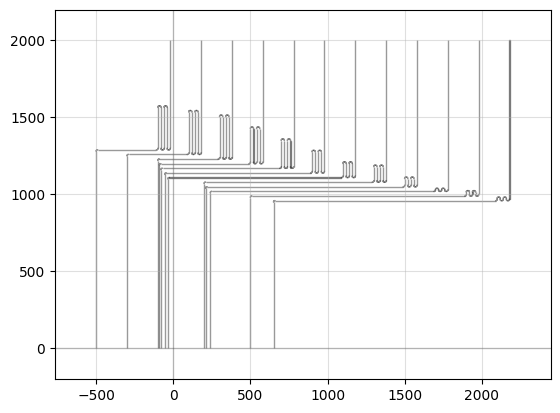

path_length_match_sample_nb_loops: uid 11ebffea, ports [], references ['bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'straight_1', 'straight_2', 'straight_3', 'straight_4', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_11', 'bend_euler_12', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'bend_euler_19', 'bend_euler_20', 'straight_8', 'straight_9', 'straight_10', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'bend_euler_25', 'bend_euler_26', 'bend_euler_27', 'bend_euler_28', 'bend_euler_29', 'bend_euler_30', 'straight_15', 'straight_16', 'straight_17', 'straight_18', 'straight_19', 'straight_20', 'straight_21', 'bend_euler_31', 'bend_euler_32', 'bend_euler_33', 'bend_euler_34', 'bend_euler_35', 'bend_euler_36', 'bend_euler_37', 'bend_euler_38', 'bend_euler_39', 'bend_euler_40', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'straight_26', 'straight_27', 'straight_28', 'bend_euler_41', 'bend_euler_42', 'bend_euler_43', 'bend_euler_44', 'bend_euler_45', 'bend_euler_46', 'bend_euler_47', 'bend_euler_48', 'bend_euler_49', 'bend_euler_50', 'straight_29', 'straight_30', 'straight_31', 'straight_32', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_51', 'bend_euler_52', 'bend_euler_53', 'bend_euler_54', 'bend_euler_55', 'bend_euler_56', 'bend_euler_57', 'bend_euler_58', 'bend_euler_59', 'bend_euler_60', 'straight_36', 'straight_37', 'straight_38', 'straight_39', 'straight_40', 'straight_41', 'straight_42', 'bend_euler_61', 'bend_euler_62', 'bend_euler_63', 'bend_euler_64', 'bend_euler_65', 'bend_euler_66', 'bend_euler_67', 'bend_euler_68', 'bend_euler_69', 'bend_euler_70', 'straight_43', 'straight_44', 'straight_45', 'straight_46', 'straight_47', 'straight_48', 'straight_49', 'bend_euler_71', 'bend_euler_72', 'bend_euler_73', 'bend_euler_74', 'bend_euler_75', 'bend_euler_76', 'bend_euler_77', 'bend_euler_78', 'bend_euler_79', 'bend_euler_80', 'straight_50', 'straight_51', 'straight_52', 'straight_53', 'straight_54', 'straight_55', 'straight_56', 'bend_euler_81', 'bend_euler_82', 'bend_euler_83', 'bend_euler_84', 'bend_euler_85', 'bend_euler_86', 'bend_euler_87', 'bend_euler_88', 'bend_euler_89', 'bend_euler_90', 'straight_57', 'straight_58', 'straight_59', 'straight_60', 'straight_61', 'straight_62', 'straight_63', 'bend_euler_91', 'bend_euler_92', 'bend_euler_93', 'bend_euler_94', 'bend_euler_95', 'bend_euler_96', 'bend_euler_97', 'bend_euler_98', 'bend_euler_99', 'bend_euler_100', 'straight_64', 'straight_65', 'straight_66', 'bend_euler_101', 'bend_euler_102', 'bend_euler_103', 'bend_euler_104', 'bend_euler_105', 'bend_euler_106', 'bend_euler_107', 'bend_euler_108', 'bend_euler_109', 'bend_euler_110', 'straight_67', 'straight_68', 'straight_69', 'straight_70', 'straight_71', 'straight_72', 'straight_73', 'bend_euler_111', 'bend_euler_112', 'bend_euler_113', 'bend_euler_114', 'bend_euler_115', 'bend_euler_116', 'bend_euler_117', 'bend_euler_118', 'bend_euler_119', 'bend_euler_120', 'straight_74', 'straight_75', 'straight_76', 'straight_77', 'straight_78', 'straight_79', 'straight_80'], 0 polygons

In [45]:
c = gf.Component("path_length_match_sample_nb_loops")

dy = 2000.0
xs1 = [-500, -300, -100, -90, -80, -55, -35, 200, 210, 240, 500, 650]

pitch = 200.0
N = len(xs1)
xs2 = [-20 + i * pitch for i in range(N)]

a1 = 90
a2 = a1 + 180
layer = (1, 0)

ports1 = [
    gf.Port(f"top_{i}", center=(xs1[i], 0), width=0.5, orientation=a1, layer=layer)
    for i in range(N)
]
ports2 = [
    gf.Port(f"bot_{i}", center=(xs2[i], dy), width=0.5, orientation=a2, layer=layer)
    for i in range(N)
]

routes = gf.routing.get_bundle_path_length_match(
    ports1, ports2, nb_loops=2, auto_widen=False
)
for route in routes:
    c.add(route.references)
    print(route.length)
c

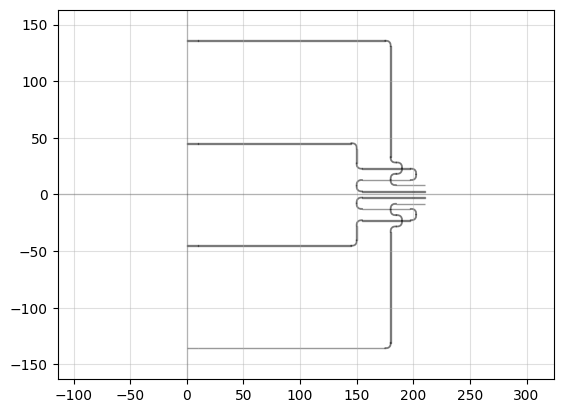

demo_problem_path_length_match: uid fe5be804, ports [], references ['straight_array_1', 'straight_array_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_4', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_9', 'straight_10', 'straight_11', 'straight_12', 'straight_13', 'bend_euler_19', 'bend_euler_20', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_14', 'straight_15', 'straight_16'], 0 polygons

In [46]:
c = gf.Component("demo_problem_path_length_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle_path_length_match(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=30,
    radius=5,
)

for route in routes:
    c.add(route.references)
c

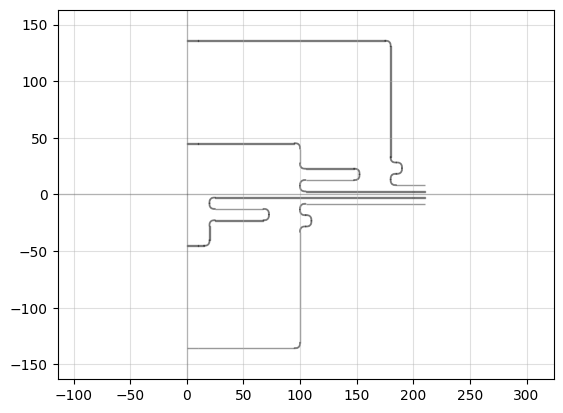

demo_solution_path_lenght_match: uid 1621be36, ports [], references ['straight_array_1', 'straight_array_2', 'bend_euler_1', 'bend_euler_2', 'bend_euler_3', 'bend_euler_4', 'bend_euler_5', 'bend_euler_6', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_4', 'straight_5', 'straight_6', 'straight_7', 'straight_8', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_9', 'straight_10', 'straight_11', 'straight_12', 'straight_13', 'bend_euler_19', 'bend_euler_20', 'bend_euler_21', 'bend_euler_22', 'bend_euler_23', 'bend_euler_24', 'straight_14', 'straight_15', 'straight_16'], 0 polygons

In [47]:
c = gf.Component("demo_solution_path_lenght_match")
c1 = c << gf.components.straight_array(spacing=90)
c2 = c << gf.components.straight_array(spacing=5)
c2.movex(200)
c1.y = 0
c2.y = 0

routes = gf.routing.get_bundle_path_length_match(
    c1.get_ports_list(orientation=0),
    c2.get_ports_list(orientation=180),
    end_straight_length=0,
    start_straight_length=0,
    separation=80,  # increased
    radius=5,
)

for route in routes:
    c.add(route.references)
c

## Route to IO (Pads, grating couplers ...)


### Route to electrical pads

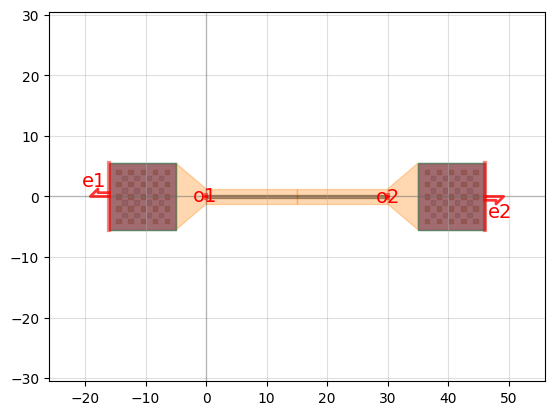

straight_heater_metal_u_3ff09402: uid dc92ffa8, ports ['o1', 'o2', 'e1', 'e2'], references ['component_sequence_1', 'via_stack_1', 'via_stack_2', 'taper_1', 'taper_2'], 0 polygons

In [48]:
mzi = gf.components.straight_heater_metal(length=30)
mzi

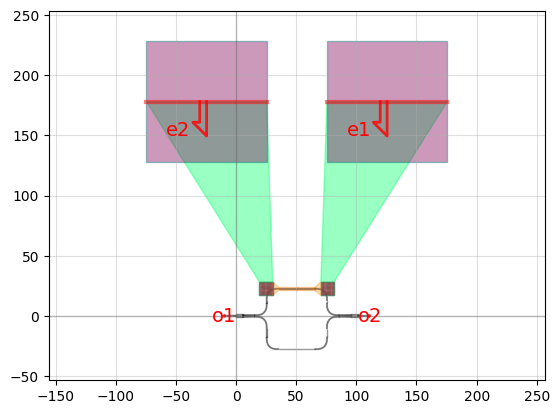

mzi_5911ef5e_add_electr_095fa141: uid abc193dc, ports ['o1', 'o2', 'e2', 'e1'], references ['mzi_1', 'pad_array_1', 'route_quad_1', 'route_quad_2'], 0 polygons

In [49]:
mzi = gf.components.mzi_phase_shifter(
    length_x=30, straight_x_top=gf.components.straight_heater_metal_90_90
)
mzi_te = gf.routing.add_electrical_pads_top(component=mzi, layer=(41, 0))
mzi_te

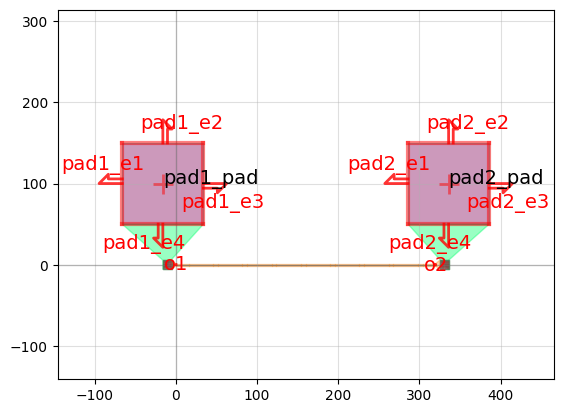

straight_heater_metal_u_7dd7b8ae: uid ecc6700b, ports ['pad1_e1', 'pad1_e2', 'pad1_e3', 'pad1_e4', 'pad1_pad', 'pad2_e1', 'pad2_e2', 'pad2_e3', 'pad2_e4', 'pad2_pad', 'o1', 'o2'], references ['straight_heater_metal_undercut_1', 'pad_1', 'route_quad_1', 'pad_2', 'route_quad_2'], 0 polygons

In [50]:
hr = gf.components.straight_heater_metal()
cc = gf.routing.add_electrical_pads_shortest(component=hr, layer=(41, 0))
cc

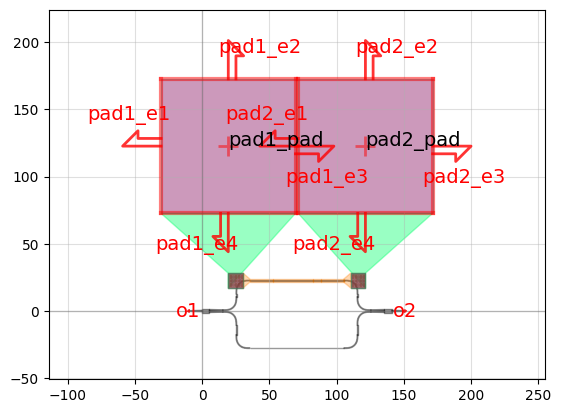

mzi_78bded51_add_electr_59d0e378: uid 6196e2dc, ports ['pad1_e1', 'pad1_e2', 'pad1_e3', 'pad1_e4', 'pad1_pad', 'pad2_e1', 'pad2_e2', 'pad2_e3', 'pad2_e4', 'pad2_pad', 'o1', 'o2'], references ['mzi_1', 'pad_1', 'route_quad_1', 'pad_2', 'route_quad_2'], 0 polygons

In [51]:
c = gf.components.mzi_phase_shifter_top_heater_metal(length_x=70)
cc = gf.routing.add_electrical_pads_shortest(component=c, layer=(41, 0))
cc

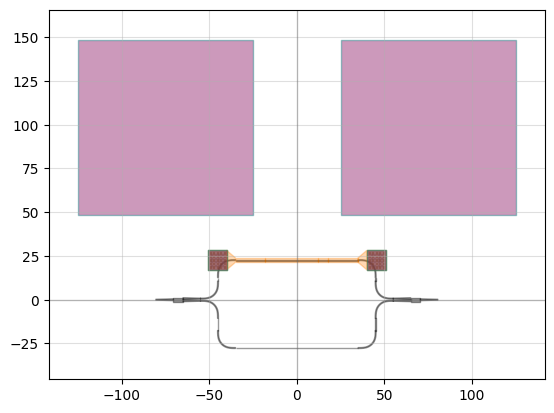

mzi_with_pads: uid e68d0292, ports [], references ['mzi_1', 'pad_array_1'], 0 polygons

In [52]:
# Solution: you can use define the pads separate and route metal lines to them

c = gf.Component("mzi_with_pads")
c1 = c << gf.components.mzi_phase_shifter_top_heater_metal(length_x=70)
c2 = c << gf.components.pad_array(columns=2)

c2.ymin = c1.ymax + 20
c2.x = 0
c1.x = 0
c

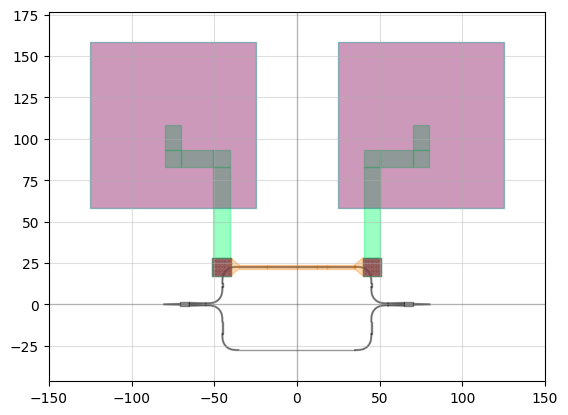

mzi_with_pads_top: uid fbc07f2e, ports [], references ['mzi_1', 'pad_array_1', 'wire_corner_1', 'wire_corner_2', 'straight_1', 'straight_2', 'straight_3', 'wire_corner_3', 'wire_corner_4', 'straight_4', 'straight_5', 'straight_6'], 0 polygons

In [53]:
c = gf.Component("mzi_with_pads_top")
c1 = c << gf.components.mzi_phase_shifter(
    straight_x_top=gf.components.straight_heater_metal_90_90, length_x=70  # 150
)
c2 = c << gf.components.pad_array(columns=2, orientation=270)

c2.ymin = c1.ymax + 30
c2.x = 0
c1.x = 0

ports1 = c1.get_ports_list(port_type="electrical")
ports2 = c2.get_ports_list()

routes = gf.routing.get_bundle(
    ports1=ports1,
    ports2=ports2,
    cross_section=gf.cross_section.metal1,
    width=10,
    bend=gf.components.wire_corner,
)
for route in routes:
    c.add(route.references)

c

### Route to Fiber Array

Routing allows you to define routes to optical or electrical IO (grating couplers or electrical pads)

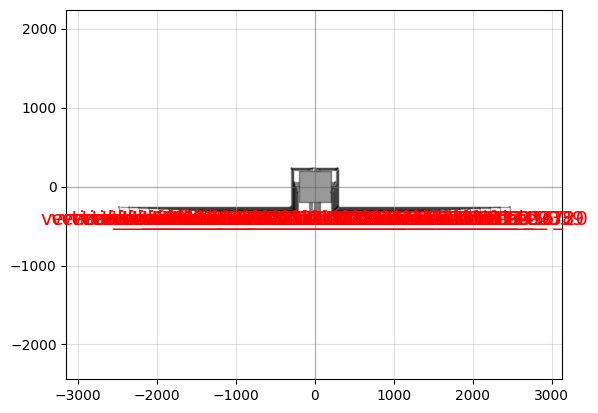

big_device_N10_add_fibe_f6639b6f: uid b5e75964, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03', 'vertical_te_04', 'vertical_te_05', 'vertical_te_06', 'vertical_te_07', 'vertical_te_08', 'vertical_te_09', 'vertical_te_010', 'vertical_te_011', 'vertical_te_012', 'vertical_te_013', 'vertical_te_014', 'vertical_te_015', 'vertical_te_016', 'vertical_te_017', 'vertical_te_018', 'vertical_te_019', 'vertical_te_020', 'vertical_te_021', 'vertical_te_022', 'vertical_te_023', 'vertical_te_024', 'vertical_te_025', 'vertical_te_026', 'vertical_te_027', 'vertical_te_028', 'vertical_te_029', 'vertical_te_030', 'vertical_te_031', 'vertical_te_032', 'vertical_te_033', 'vertical_te_034', 'vertical_te_035', 'vertical_te_036', 'vertical_te_037', 'vertical_te_038', 'vertical_te_039', 'vertical_te_10', 'vertical_te_20'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'straight_5', 'straight_6', 'bend_euler_4', 'straight_7', 'straight_8', 'bend_euler_5', 'straight_9', 'straight_10', 'bend_euler_6', 'straight_11', 'straight_12', 'bend_euler_7', 'straight_13', 'straight_14', 'bend_euler_8', 'straight_15', 'straight_16', 'bend_euler_9', 'straight_17', 'straight_18', 'bend_euler_10', 'straight_19', 'straight_20', 'bend_euler_11', 'bend_euler_12', 'straight_21', 'straight_22', 'straight_23', 'bend_euler_13', 'bend_euler_14', 'straight_24', 'straight_25', 'straight_26', 'bend_euler_15', 'bend_euler_16', 'straight_27', 'straight_28', 'straight_29', 'bend_euler_17', 'bend_euler_18', 'straight_30', 'straight_31', 'straight_32', 'bend_euler_19', 'bend_euler_20', 'straight_33', 'straight_34', 'straight_35', 'bend_euler_21', 'straight_36', 'straight_37', 'bend_euler_22', 'straight_38', 'straight_39', 'bend_euler_23', 'straight_40', 'straight_41', 'bend_euler_24', 'straight_42', 'straight_43', 'bend_euler_25', 'straight_44', 'straight_45', 'bend_euler_26', 'straight_46', 'straight_47', 'bend_euler_27', 'straight_48', 'straight_49', 'bend_euler_28', 'straight_50', 'straight_51', 'bend_euler_29', 'straight_52', 'straight_53', 'bend_euler_30', 'straight_54', 'straight_55', 'bend_euler_31', 'bend_euler_32', 'straight_56', 'straight_57', 'straight_58', 'bend_euler_33', 'bend_euler_34', 'straight_59', 'straight_60', 'straight_61', 'bend_euler_35', 'bend_euler_36', 'straight_62', 'straight_63', 'straight_64', 'bend_euler_37', 'bend_euler_38', 'straight_65', 'straight_66', 'straight_67', 'bend_euler_39', 'bend_euler_40', 'straight_68', 'straight_69', 'straight_70', 'bend_euler_41', 'bend_euler_42', 'straight_71', 'straight_72', 'straight_73', 'bend_euler_43', 'bend_euler_44', 'straight_74', 'straight_75', 'straight_76', 'bend_euler_45', 'bend_euler_46', 'straight_77', 'straight_78', 'straight_79', 'bend_euler_47', 'bend_euler_48', 'straight_80', 'straight_81', 'straight_82', 'bend_euler_49', 'bend_euler_50', 'straight_83', 'straight_84', 'straight_85', 'bend_euler_51', 'bend_euler_52', 'straight_86', 'straight_87', 'straight_88', 'bend_euler_53', 'bend_euler_54', 'straight_89', 'straight_90', 'straight_91', 'bend_euler_55', 'bend_euler_56', 'straight_92', 'straight_93', 'straight_94', 'bend_euler_57', 'bend_euler_58', 'straight_95', 'straight_96', 'straight_97', 'bend_euler_59', 'bend_euler_60', 'straight_98', 'straight_99', 'straight_100', 'bend_euler_61', 'bend_euler_62', 'straight_101', 'straight_102', 'straight_103', 'bend_euler_63', 'bend_euler_64', 'straight_104', 'straight_105', 'straight_106', 'bend_euler_65', 'bend_euler_66', 'straight_107', 'straight_108', 'straight_109', 'bend_euler_67', 'bend_euler_68', 'straight_110', 'straight_111', 'straight_112', 'bend_euler_69', 'bend_euler_70', 'straight_113', 'straight_114', 'straight_115', 'bend_euler_71', 'bend_euler_72', 'straight_116', 'straight_117', 'straight_118', 'bend_euler_73', 'bend_euler_74', 'straight_119', 'straight_120', 'straight_121', 'bend_euler_75', 'bend_euler_76', 'straight_122', 'straight_123', 'st

In [54]:
@gf.cell
def big_device(w=400.0, h=400.0, N=16, port_pitch=15.0, layer=LAYER.WG, wg_width=0.5):
    """big component with N ports on each side"""
    component = gf.Component()
    p0 = np.array((0, 0))
    dx = w / 2
    dy = h / 2

    points = [[dx, dy], [dx, -dy], [-dx, -dy], [-dx, dy]]
    component.add_polygon(points, layer=layer)
    port_params = {"layer": layer, "width": wg_width}
    for i in range(N):
        port = Port(
            name=f"W{i}",
            center=p0 + (-dx, (i - N / 2) * port_pitch),
            orientation=180,
            **port_params,
        )

        component.add_port(port)

    for i in range(N):
        port = Port(
            name=f"E{i}",
            center=p0 + (dx, (i - N / 2) * port_pitch),
            orientation=0,
            **port_params,
        )

        component.add_port(port)

    for i in range(N):
        port = Port(
            name=f"N{i}",
            center=p0 + ((i - N / 2) * port_pitch, dy),
            orientation=90,
            **port_params,
        )

        component.add_port(port)

    for i in range(N):
        port = Port(
            name=f"S{i}",
            center=p0 + ((i - N / 2) * port_pitch, -dy),
            orientation=-90,
            **port_params,
        )

        component.add_port(port)
    return component


component = big_device(N=10)
c = gf.routing.add_fiber_array(component=component, radius=10.0, fanout_length=60.0)
c

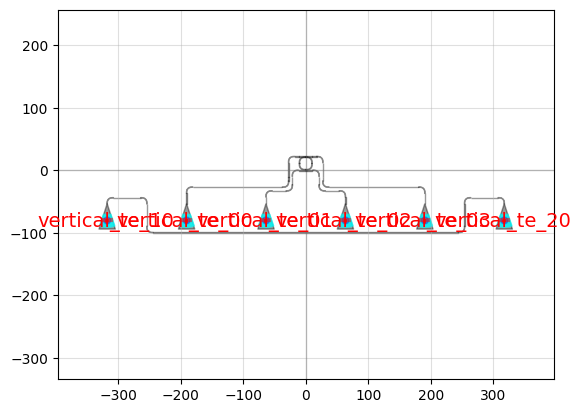

ring_double_width0p8_ad_1d2d7470: uid 05bb2b33, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_02', 'vertical_te_03', 'vertical_te_10', 'vertical_te_20'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'straight_5', 'straight_6', 'bend_euler_4', 'straight_7', 'straight_8', 'bend_euler_5', 'bend_euler_6', 'straight_9', 'straight_10', 'straight_11', 'bend_euler_7', 'bend_euler_8', 'straight_12', 'straight_13', 'straight_14', 'bend_euler_9', 'bend_euler_10', 'straight_15', 'straight_16', 'straight_17', 'bend_euler_11', 'bend_euler_12', 'straight_18', 'straight_19', 'straight_20', 'bend_euler_13', 'bend_euler_14', 'bend_euler_15', 'bend_euler_16', 'bend_euler_17', 'bend_euler_18', 'straight_21', 'straight_22', 'straight_23', 'straight_24', 'straight_25', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'grating_coupler_elliptical_trenches_5', 'grating_coupler_elliptical_trenches_6', 'ring_double_1'], 0 polygons

In [55]:
c = gf.components.ring_double(width=0.8)
cc = gf.routing.add_fiber_array(component=c, taper_length=150)
cc

You can also mix and match `TE` and `TM` grating couplers

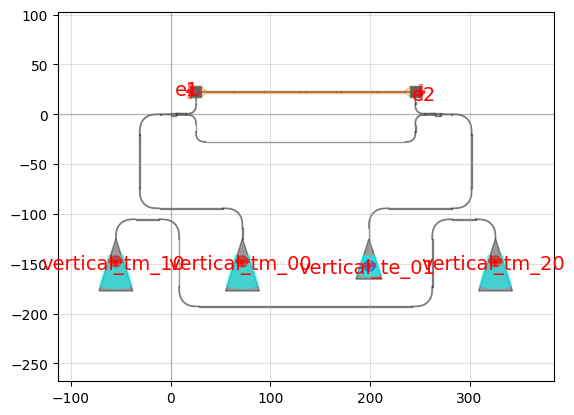

mzi_7a18d033_add_fiber__ab00580f: uid 769db5e6, ports ['e1', 'e2', 'vertical_tm_00', 'vertical_te_01', 'vertical_tm_10', 'vertical_tm_20'], references ['bend_euler_1', 'straight_1', 'straight_2', 'bend_euler_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'straight_5', 'straight_6', 'straight_7', 'bend_euler_5', 'bend_euler_6', 'straight_8', 'straight_9', 'straight_10', 'bend_euler_7', 'bend_euler_8', 'bend_euler_9', 'bend_euler_10', 'bend_euler_11', 'bend_euler_12', 'straight_11', 'straight_12', 'straight_13', 'straight_14', 'straight_15', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4', 'mzi_1'], 0 polygons

In [56]:
c = gf.components.mzi_phase_shifter()
gcte = gf.components.grating_coupler_te
gctm = gf.components.grating_coupler_tm

cc = gf.routing.add_fiber_array(
    component=c,
    optical_routing_type=2,
    grating_coupler=[gctm, gcte, gctm, gcte],
    radius=20,
)
cc

### Route to fiber single

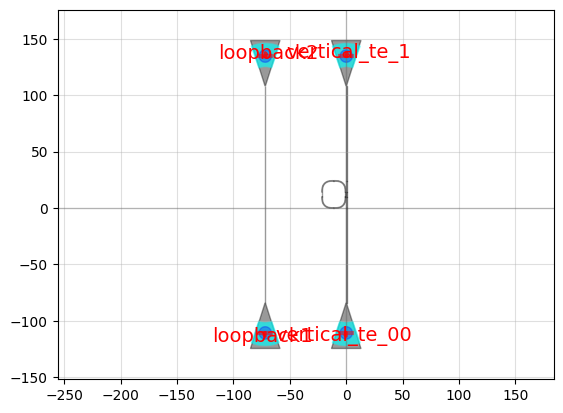

ring_single_move_edcdd0_45bdf2e6: uid bf5e396c, ports ['vertical_te_00', 'vertical_te_1', 'loopback1', 'loopback2'], references ['move_1', 'straight_1', 'straight_2', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'straight_3', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4'], 0 polygons

In [57]:
c = gf.components.ring_single()
cc = gf.routing.add_fiber_single(component=c)
cc

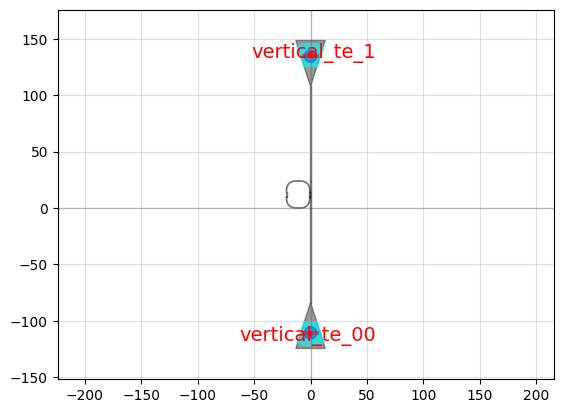

ring_single_move_edcdd0_ce3f64b7: uid 0d141aec, ports ['vertical_te_00', 'vertical_te_1'], references ['move_1', 'straight_1', 'straight_2', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2'], 0 polygons

In [58]:
c = gf.components.ring_single()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc

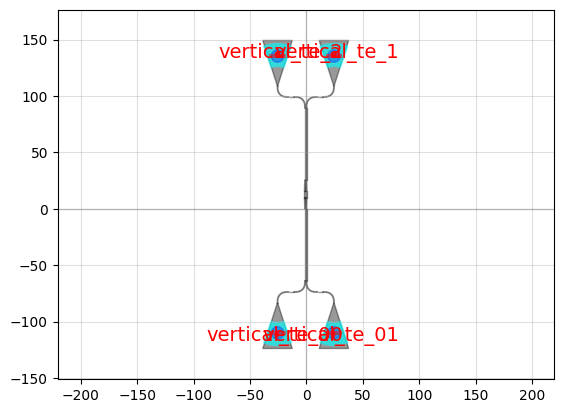

mmi2x2_move_db13b55c_ad_40021266: uid 6c06610e, ports ['vertical_te_00', 'vertical_te_01', 'vertical_te_1', 'vertical_te_2'], references ['move_1', 'bend_euler_1', 'bend_euler_2', 'straight_1', 'straight_2', 'straight_3', 'bend_euler_3', 'bend_euler_4', 'straight_4', 'straight_5', 'straight_6', 'bend_euler_5', 'bend_euler_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_7', 'bend_euler_8', 'straight_10', 'straight_11', 'straight_12', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4'], 0 polygons

In [59]:
c = gf.components.mmi2x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc

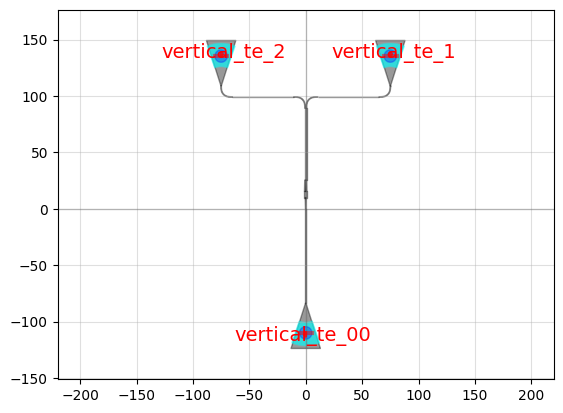

mmi1x2_move_96ec6b81_ad_b6b66598: uid c7688d24, ports ['vertical_te_00', 'vertical_te_1', 'vertical_te_2'], references ['move_1', 'straight_1', 'bend_euler_1', 'bend_euler_2', 'straight_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'straight_5', 'straight_6', 'straight_7', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3'], 0 polygons

In [60]:
c = gf.components.mmi1x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False, fiber_spacing=150)
cc

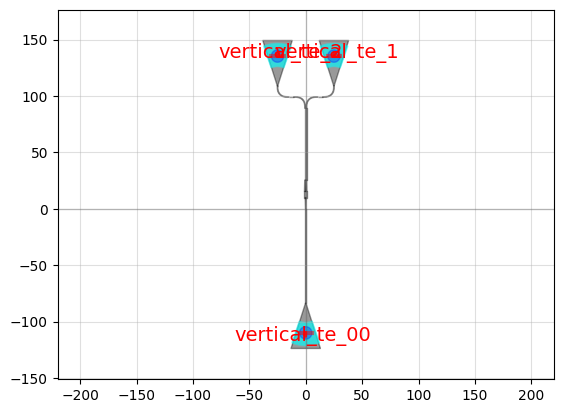

mmi1x2_move_96ec6b81_ad_c7418f18: uid c1ff2182, ports ['vertical_te_00', 'vertical_te_1', 'vertical_te_2'], references ['move_1', 'straight_1', 'bend_euler_1', 'bend_euler_2', 'straight_2', 'straight_3', 'straight_4', 'bend_euler_3', 'bend_euler_4', 'straight_5', 'straight_6', 'straight_7', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3'], 0 polygons

In [61]:
c = gf.components.mmi1x2()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False, fiber_spacing=50)
cc

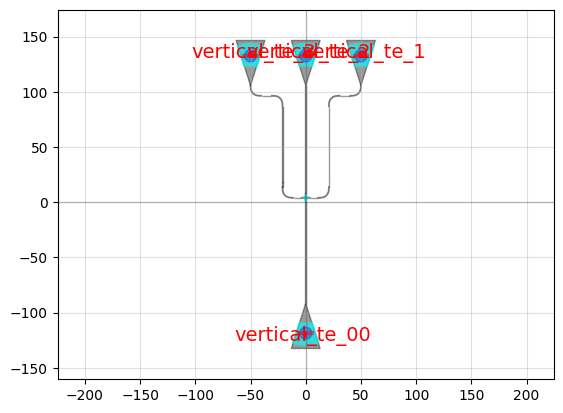

crossing_move_d188f4d9__5bc99fe6: uid 532cd861, ports ['vertical_te_00', 'vertical_te_1', 'vertical_te_2', 'vertical_te_3'], references ['move_1', 'straight_1', 'bend_euler_1', 'straight_2', 'straight_3', 'bend_euler_2', 'straight_4', 'straight_5', 'bend_euler_3', 'bend_euler_4', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_5', 'bend_euler_6', 'straight_10', 'straight_11', 'straight_12', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4'], 0 polygons

In [62]:
c = gf.components.crossing()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc

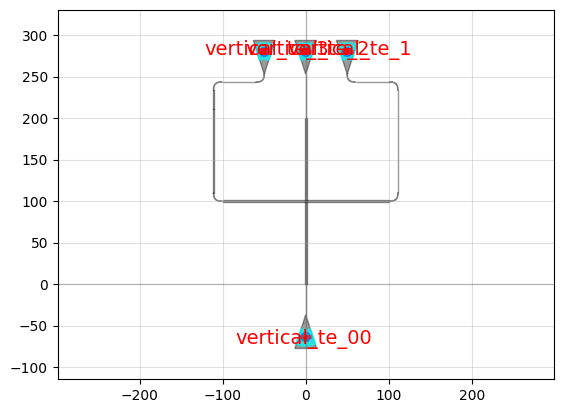

cross_9bc31ebd_move_5ce_f9c13fa1: uid 08caf339, ports ['vertical_te_00', 'vertical_te_1', 'vertical_te_2', 'vertical_te_3'], references ['move_1', 'straight_1', 'bend_euler_1', 'straight_2', 'straight_3', 'bend_euler_2', 'straight_4', 'straight_5', 'bend_euler_3', 'bend_euler_4', 'straight_6', 'straight_7', 'straight_8', 'straight_9', 'bend_euler_5', 'bend_euler_6', 'straight_10', 'straight_11', 'straight_12', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2', 'grating_coupler_elliptical_trenches_3', 'grating_coupler_elliptical_trenches_4'], 0 polygons

In [63]:
c = gf.components.cross(length=200, width=2, port_type="optical")
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc

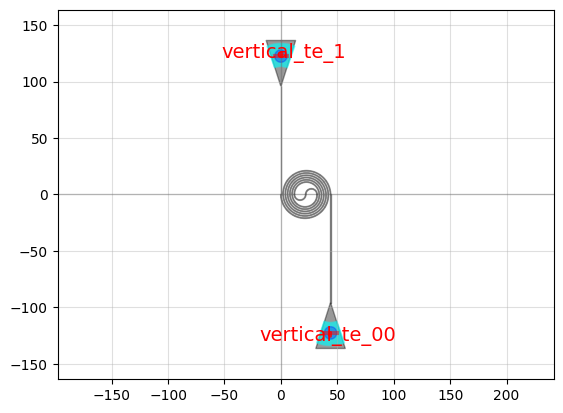

spiral_double_move_269c_54e48bc5: uid a105c431, ports ['vertical_te_00', 'vertical_te_1'], references ['move_1', 'straight_1', 'straight_2', 'grating_coupler_elliptical_trenches_1', 'grating_coupler_elliptical_trenches_2'], 0 polygons

In [64]:
c = gf.components.spiral_double()
cc = gf.routing.add_fiber_single(component=c, with_loopback=False)
cc